# Analysis and figures

Saoirse Kelleher  
September 23, 2024

Calculates key statistics and renders figures for “*Twenty years of dynamic occupancy models: a review of applications and look to the future*”

## Load packages

Required packages for analysis and plotting figures.

In [ ]:

library(tidyverse)


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Linking to GEOS 3.11.0, GDAL 3.5.3, PROJ 9.1.0; sf_use_s2() is TRUE

## Load data

Two sources of data are loaded in for analysis:

-   Randomised list of all queried articles

-   Spreadsheet of included articles

#### Randomised articles

All queried articles were assigned random values in *‘Randomisation.qmd’* to determine the order in which they were considered for inclusion in this review. These articles are read in from *‘Randomisation.xlsx’*.

In [ ]:
sheet_AllArticles <- list(read_xlsx("Randomisation/Randomisation.xlsx", 
                                    sheet = "2004-2007"),
                          read_xlsx("Randomisation/Randomisation.xlsx", 
                                    sheet = "2008-2011"),
                          read_xlsx("Randomisation/Randomisation.xlsx", 
                                    sheet = "2012-2015"),
                          read_xlsx("Randomisation/Randomisation.xlsx", 
                                    sheet = "2016-2019"),
                          read_xlsx("Randomisation/Randomisation.xlsx", 
                                    sheet = "2020-2023")) |> 
  list_rbind()


#### Reviewed data

Each sheet from *‘Review_Spreadsheet.xlsx’* is loaded individually.

In [ ]:
sheet_ArticleData <- read_xlsx("Review_Spreadsheet.xlsx",
                               sheet = "Article Data")
sheet_Objectives <- read_xlsx("Review_Spreadsheet.xlsx",
                              sheet = "Objectives") 
sheet_FocalTaxa <- read_xlsx("Review_Spreadsheet.xlsx",
                             sheet = "Focal Taxa") 
sheet_StudyArea <- read_xlsx("Review_Spreadsheet.xlsx",
                             sheet = "Study Area")
sheet_DataCollection <- read_xlsx("Review_Spreadsheet.xlsx",
                                  sheet = "Data Collection")
sheet_Covariates <- read_xlsx("Review_Spreadsheet.xlsx",
                              sheet = "Covariates")
sheet_Modelling <- read_xlsx("Review_Spreadsheet.xlsx",
                             sheet = "Modelling")


## Article inclusion

#### Articles by query

Calculate the number of articles sourced from each query, and the proportion of articles which were included in both queries.

In [ ]:
sheet_AllArticles |>
  mutate(Query = case_when(KeyTerms == TRUE & CitesMackenzie == TRUE ~ "Both",
                           KeyTerms == FALSE & CitesMackenzie == TRUE ~ "Mackenzie",
                           KeyTerms == TRUE & CitesMackenzie == FALSE ~ "KeyTerms")) |>
  summarise(Articles = n(), .by = Query) |>
  mutate(Proportion = round(Articles/sum(Articles), 2))


# A tibble: 3 × 3
  Query     Articles Proportion
  <chr>        <int>      <dbl>
1 Both           298       0.2 
2 Mackenzie      897       0.61
3 KeyTerms       274       0.19

#### Total articles

Get the number of included articles

In [ ]:
sheet_AllArticles |>
  filter(Included == "YES") |>
  nrow()


[1] 92

#### Article hit rates

Calculate the hit rate for articles in each stratum, and determine how many articles are estimated to remain in each stratum based off of those hit rates.

In [ ]:
# Hit rates within each stratum
stratumHitRates <- sheet_AllArticles |>
  summarise(Articles = n(), .by = c(Year, Strata, Included)) |>
  pivot_wider(names_from = Included, 
              values_from = Articles, values_fill = 0) |>
  summarise(HitRate = round(sum(YES)/(sum(NO)+sum(YES)), 2),
            .by = Strata)
stratumHitRates


# A tibble: 5 × 2
  Strata    HitRate
  <chr>       <dbl>
1 2004-2007    0.12
2 2008-2011    0.24
3 2012-2015    0.43
4 2016-2019    0.35
5 2020-2023    0.57

# A tibble: 20 × 2
    Year EstRemaining
   <dbl>        <dbl>
 1  2006         0   
 2  2007         0   
 3  2005         0   
 4  2004         0   
 5  2010         8.05
 6  2008         4.63
 7  2009         6.83
 8  2011        12.2 
 9  2015        34.0 
10  2013        30.6 
11  2012        28.9 
12  2014        31.9 
13  2019        35.8 
14  2018        32.6 
15  2017        30.5 
16  2016        23.5 
17  2021        60   
18  2023        42.3 
19  2022        52   
20  2020        61.7 

            Group Articles
1    EstRemaining    495.7
2 TotalUnreviewed   1152.0

#### Coverage figure

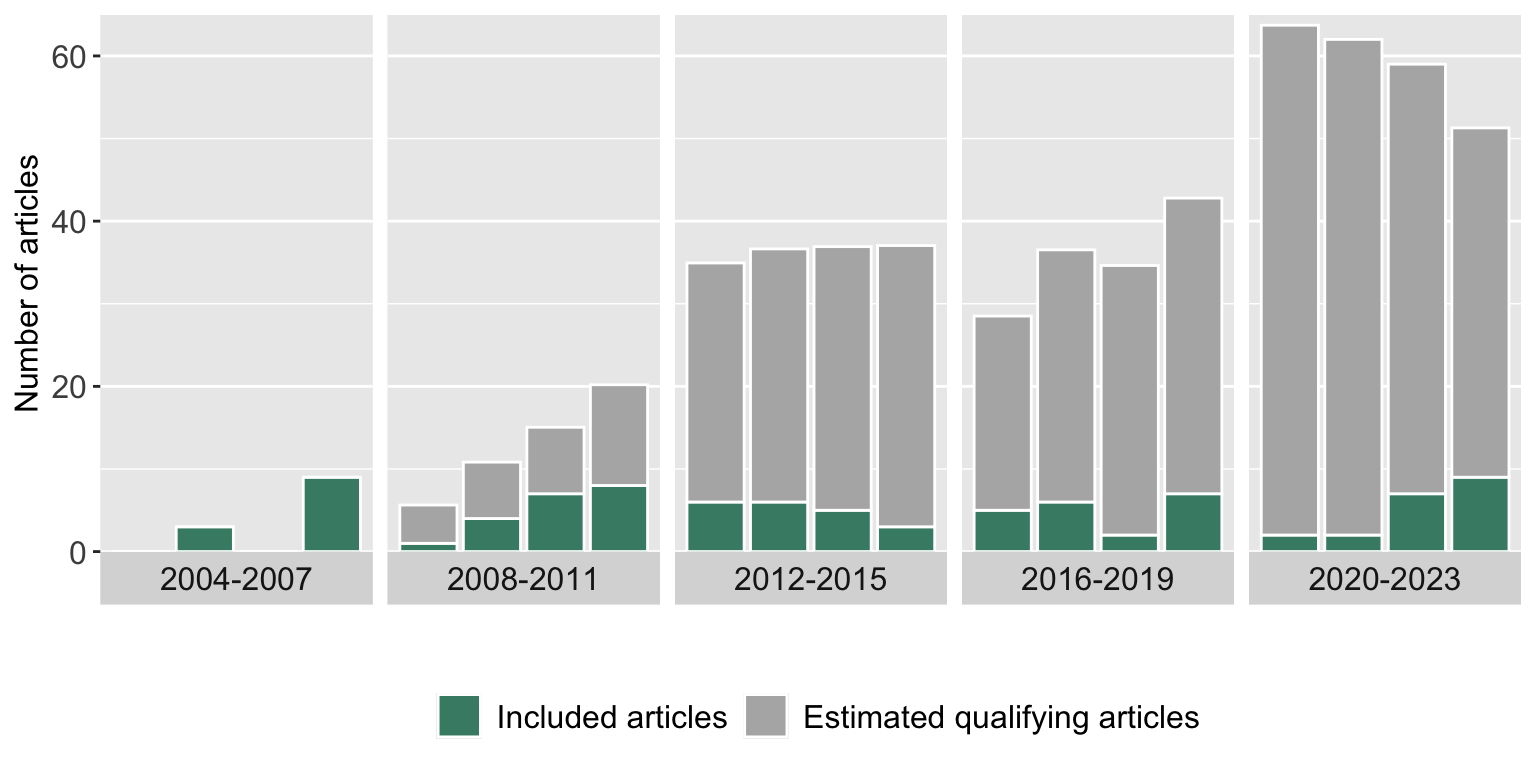

In [ ]:

plot_coverage <- 
  sheet_AllArticles |>
  summarise(N = n(), .by = c(Year, Strata, Included)) |>
  pivot_wider(names_from = Included, values_from = N, values_fill = 0) |>
  mutate(HitRate = sum(YES)/(sum(NO)+sum(YES)),
         .by = Strata) |>
  mutate(EstRemaining = `NA`*HitRate) |>
  pivot_longer(cols = c(YES, EstRemaining), 
               names_to = 'Group', values_to = 'Articles') |>
  
  ggplot() +
  geom_col(aes(x = Year, y = Articles, fill = Group), colour = "white") +
  scale_fill_manual("",
                    limits = c("YES", "EstRemaining"),
                    labels = c("Included articles", 
                               "Estimated qualifying articles"),
                    values = c("aquamarine4", "gray70")) +
  scale_y_continuous(expand = c(0,0), limits = c(0, 65)) +
  labs(x = "", y = "Number of articles") +
  theme(panel.grid.major.x = element_blank(),
        panel.grid.minor.x = element_blank(),
        legend.position = "bottom", 
        axis.text = element_text(size = 12),
        axis.text.x = element_blank(), 
        axis.ticks.x = element_blank(),
        axis.title = element_text(size = 12), 
        legend.text = element_text(size = 12),
        strip.text.x = element_text(size = 12)) +
  facet_grid(cols = vars(Strata), scales = "free_x", switch = "x")
plot_coverage


## Study areas

#### Study countries table

In [ ]:
sheet_StudyArea |>
  select(`Review ID`, Country) |>
  separate_longer_delim(Country, ", ") |>
  distinct() |>
  summarise(Articles = n(), .by = Country) |>
  arrange(-Articles)


# A tibble: 27 × 2
   Country                  Articles
   <chr>                       <int>
 1 United States of America       55
 2 Canada                          6
 3 Italy                           5
 4 Switzerland                     5
 5 France                          4
 6 Australia                       4
 7 Brazil                          2
 8 Costa Rica                      2
 9 New Zealand                     2
10 Panama                          1
# ℹ 17 more rows

#### Unique countries

In [ ]:
sheet_StudyArea |>
  select(`Review ID`, Country) |>
  separate_longer_delim(Country, ", ") |>
  pull(Country) |>
  unique() |>
  length()


[1] 27

#### Map of study locations

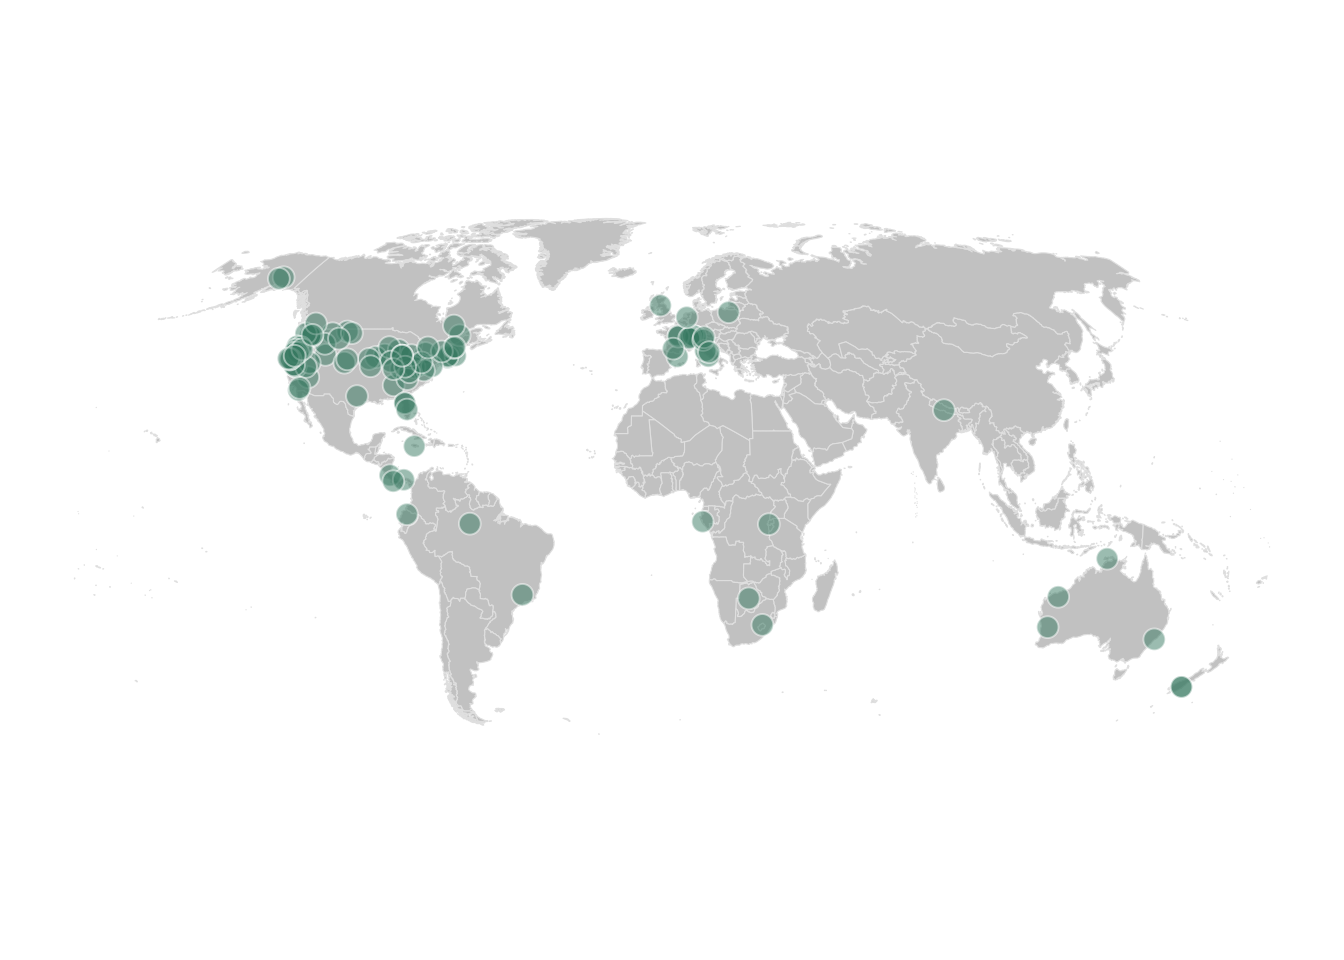

Saving 7 x 5 in image

In [ ]:
# Load country shapefile
countries_shp <- st_read("Analysis/Countries_Spatial/World_Countries__Generalized_.shp", quiet = TRUE) |>
  st_transform(crs = "ESRI:54030") |>
  filter(COUNTRY != "Antarctica")

studyArea_Map <- sheet_StudyArea |>
  st_as_sf(coords = c("Centre Point (lon)", "Centre Point (lat)"),
           crs = "EPSG:4326") |>
  st_transform(crs = "ESRI:54030") |>
  
  ggplot() +
  geom_sf(data = countries_shp, colour = "gray90", fill = "gray80") +
  geom_sf(shape = 21, fill = "aquamarine4", colour = "white", alpha = 0.5, size = 3.5) +
  theme(axis.text.x = element_blank(), axis.ticks.x = element_blank(),
        panel.background = element_rect(fill='transparent', color=NA),
        plot.background = element_rect(fill='transparent', color=NA),
        panel.grid.major = element_blank(), panel.grid.minor = element_blank()) 
studyArea_Map


#### Study area size

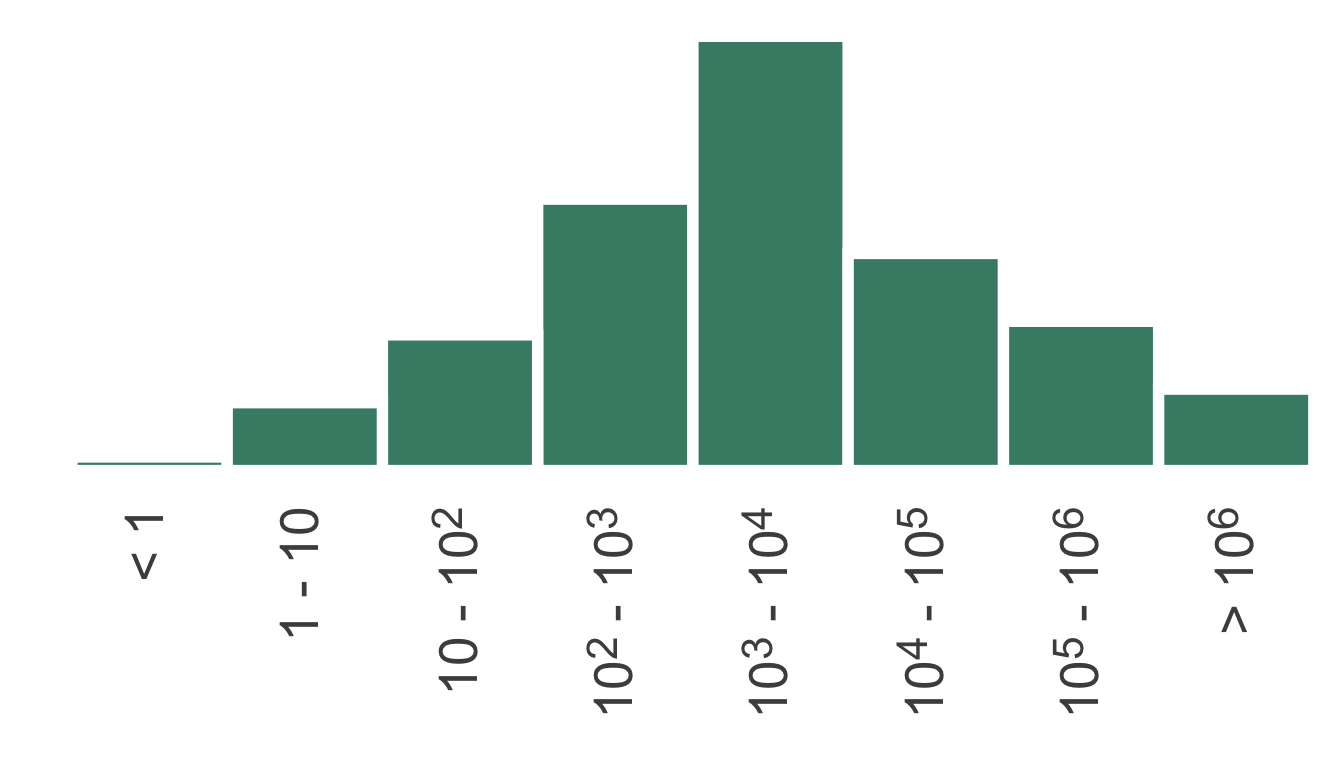

In [ ]:

studyAreaPlot <- sheet_StudyArea |>
  summarise(Articles = n(), .by = Size) |>
  filter(Size != "Unspecified") |>
  
  ggplot() +
  geom_col(aes(x = Size, y = Articles),
           fill = "aquamarine4", colour = "white",
           width = 1, linewidth = 2) +
  labs(x = "", y = "") +
  scale_x_discrete(labels = c("< 1", "1 - 10", "10 - 10<sup>2</sup>",
                              "10<sup>2</sup> - 10<sup>3</sup>",
                              "10<sup>3</sup> - 10<sup>4</sup>",
                              "10<sup>4</sup> - 10<sup>5</sup>",
                              "10<sup>5</sup> - 10<sup>6</sup>",
                              "\\> 10<sup>6</sup>")) +
  theme(panel.grid = element_blank(),
        axis.text.x = element_markdown(size = 20, angle = 90,
                                       vjust = 0.5, hjust = 1),
        axis.text.y = element_blank(), axis.ticks = element_blank(),
        panel.background = element_rect(fill='transparent', color=NA),
        plot.background = element_rect(fill='transparent', color=NA))
studyAreaPlot


## Study taxa

#### Multi-species statistics

In [ ]:
sheet_FocalTaxa |>
  separate_longer_delim(`Multispecies method`, ", ") |>
  select(`Review ID`, `Multispecies method`) |>
  distinct() |>
  mutate(TotalArticles = length(unique(`Review ID`))) |>
  summarise(Articles = n(), 
            .by = c(`Multispecies method`, TotalArticles)) |>
  mutate(Proportion = round(Articles/TotalArticles, 2))


# A tibble: 4 × 4
  `Multispecies method` TotalArticles Articles Proportion
  <chr>                         <int>    <int>      <dbl>
1 Independent                      92       31       0.34
2 Joint                            92        8       0.09
3 Single                           92       54       0.59
4 Interactive                      92        3       0.03

#### Study species

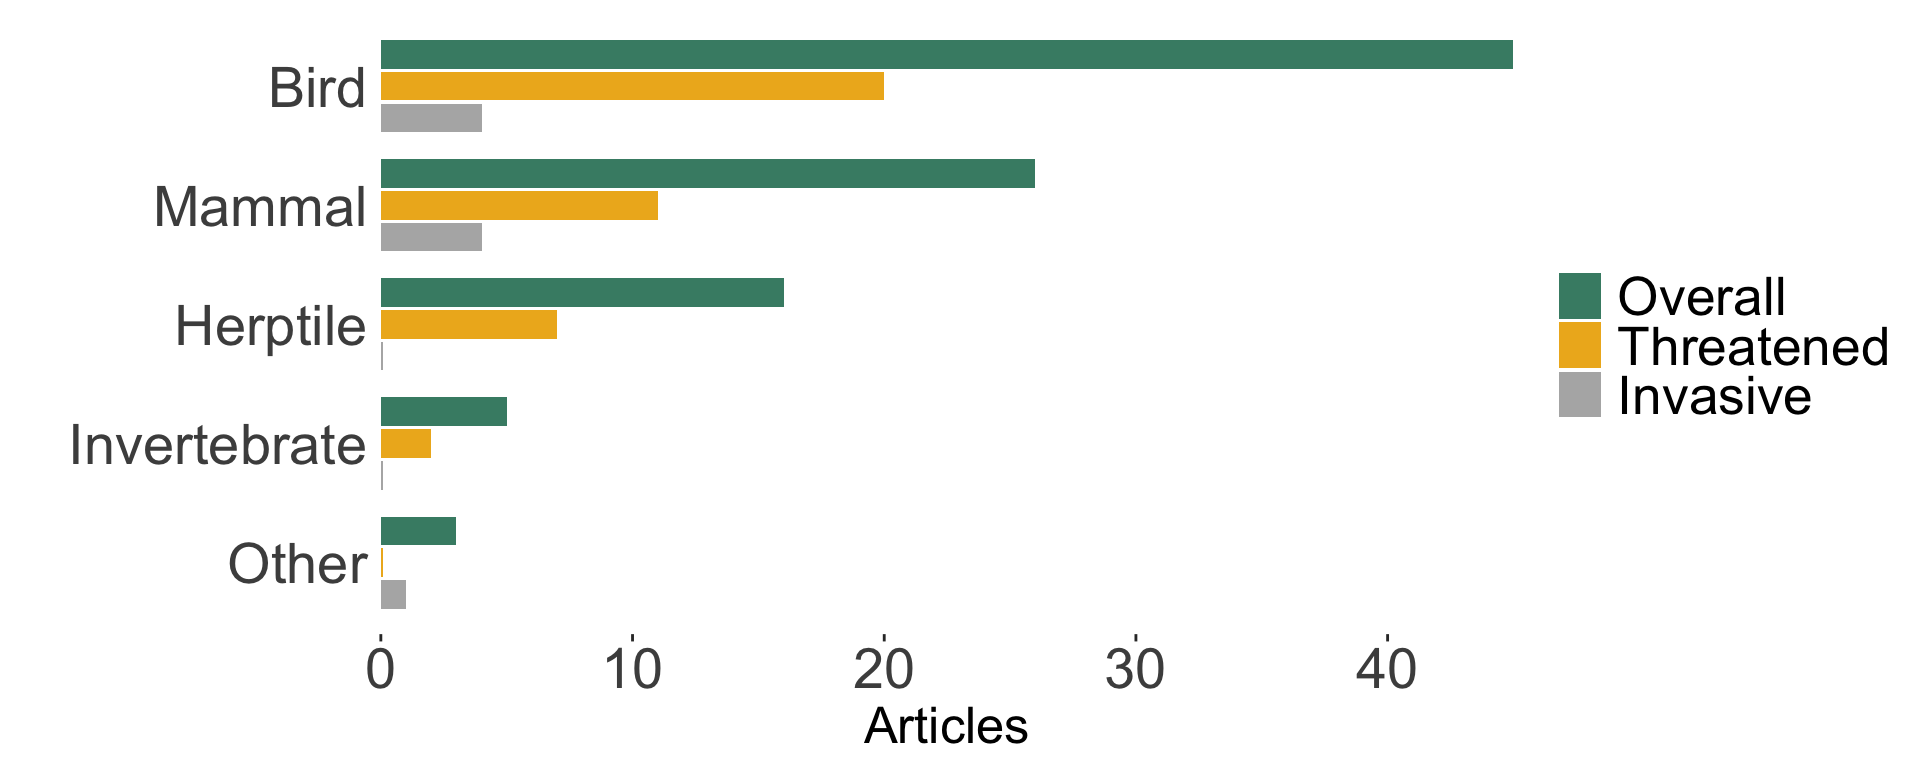

In [ ]:

focalTaxaPlot <- 
  sheet_FocalTaxa |>
  separate_longer_delim(`Taxa keywords`, delim = ", ") |>
  separate_longer_delim(Status, delim = ", ") |>
  mutate(`Taxa keywords` = case_when(`Taxa keywords` == "Fish" ~ "Other", 
                                     .default = `Taxa keywords`)) |>
  mutate(Status = case_when(Status %in% c("CR", "EN", "NT", "VU", "Threatened_Other") ~ "Threatened",
                            Status %in% c("NA", "Unclear", "DD") ~ "NA",
                            Status == "Invasive" ~ "Invasive",
                            Status == "LC" ~ "Stable")) |>
  mutate(Threatened = case_when("Threatened" %in% Status ~ TRUE,
                                .default = FALSE),
         Invasive = case_when("Invasive" %in% Status ~ TRUE,
                              .default = FALSE),
         Overall = TRUE,
         .by = c(`Review ID`, `Taxa keywords`)) |>
  select(`Review ID`, `Taxa keywords`, Threatened, Invasive, Overall) |>
  distinct() |>
  pivot_longer(cols = c(Threatened, Invasive, Overall), 
               names_to = "Group", values_to = "Value") |>
  summarise(Articles = sum(Value),
            .by = c(`Taxa keywords`, Group)) |>
  mutate(Group = fct(Group, levels = c("Overall", "Threatened",
                                       "Invasive"))) |>
  mutate(`Taxa keywords` = fct(`Taxa keywords`, 
                               levels = rev(c("Bird", "Mammal", "Herptile",
                                              "Invertebrate", "Other")))) |>
  mutate(Articles = case_when(Articles == 0 ~ 0.1, .default = Articles)) |>
  
  ggplot() +
  geom_col(aes(x = Articles, y = `Taxa keywords`, fill = Group),
           position = position_dodge2(reverse = TRUE), width = 0.8) +
  scale_fill_manual("", values = c("aquamarine4", "goldenrod2", "gray70")) +
  scale_x_continuous(expand = c(0,0)) +
  labs(x = "Articles", y = "") +
  theme(panel.grid = element_blank(),
        legend.text = element_text(size = 20), axis.text = element_text(size = 21),
        axis.title = element_text(size = 19), axis.ticks.y = element_blank(),
        panel.background = element_rect(fill='transparent', color = NA),
        plot.background = element_rect(fill='transparent', color = NA),
        legend.background = element_rect(fill = 'transparent', color = NA))
focalTaxaPlot


## Data collection

#### Survey method statistics

In [ ]:
sheet_DataCollection |>
  separate_longer_delim(`Capture method`, ", ") |>
  select(`Review ID`, `Capture method`) |>
  distinct() |>
  mutate(TotalArticles = length(unique(`Review ID`))) |>
  summarise(Articles = n(), .by = c(`Capture method`, TotalArticles)) |>
  mutate(Proportion = round(Articles/TotalArticles, 2))


# A tibble: 4 × 4
  `Capture method` TotalArticles Articles Proportion
  <chr>                    <int>    <int>      <dbl>
1 Trapping                    92       10       0.11
2 Human                       92       73       0.79
3 Camera                      92       13       0.14
4 Other                       92        3       0.03

[1] 13

#### Site quantity

ℹ In argument: `Site quantity = as.numeric(`Site quantity`)`.
Caused by warning:
! NAs introduced by coercion

(`stat_bin()`).

(`geom_bar()`).

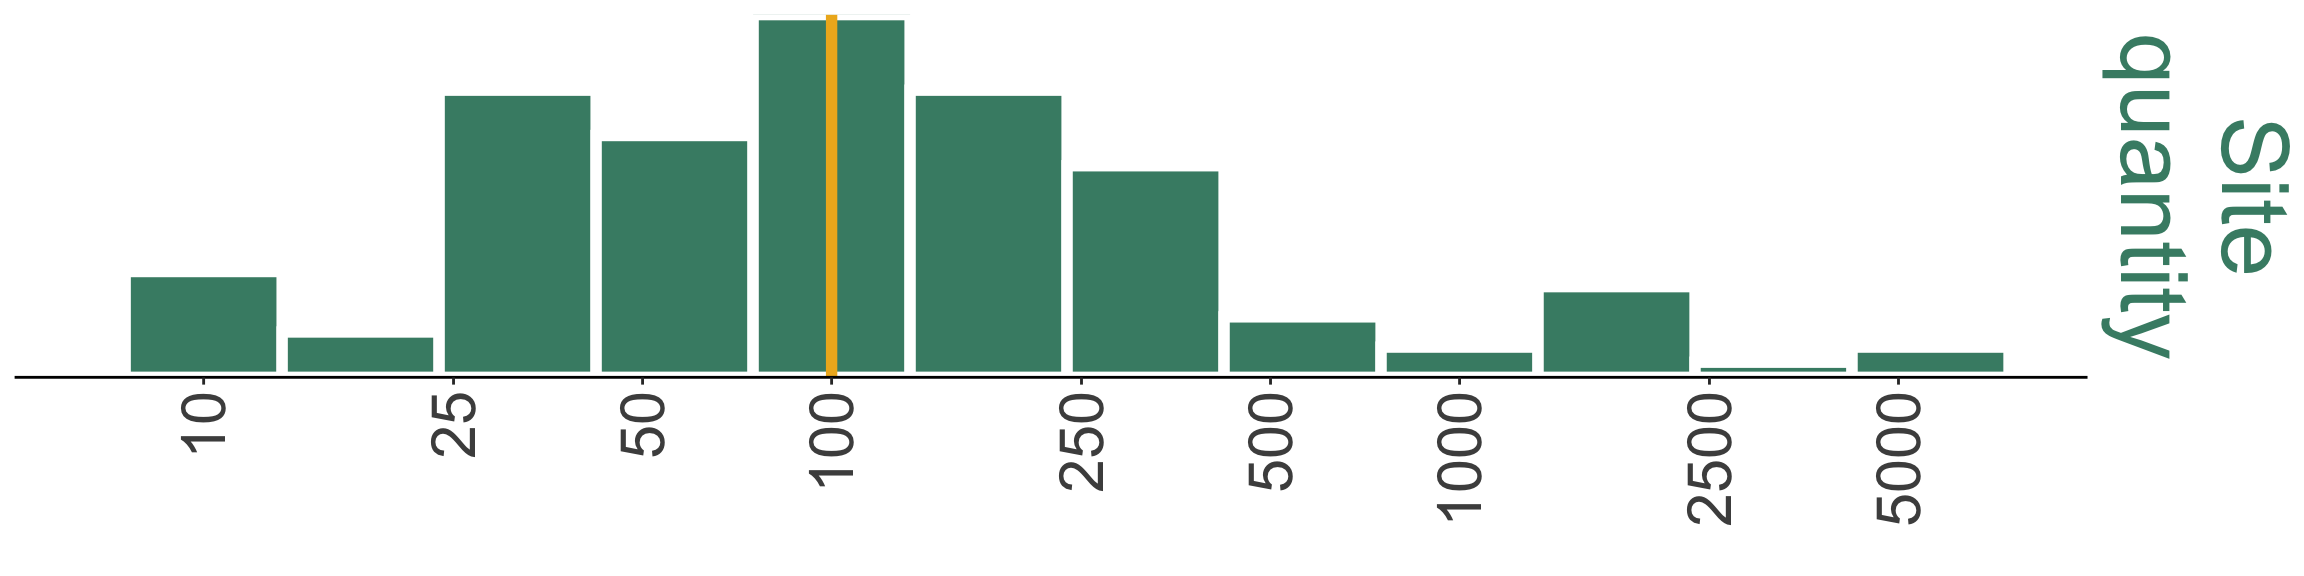

Removed 2 rows containing missing values or values outside the scale range
(`geom_bar()`).

In [ ]:

siteQuantityPlot <- sheet_DataCollection |>
  mutate(`Site quantity` = as.numeric(`Site quantity`)) |>
  ggplot() +
  geom_histogram(aes(x = `Site quantity`),
                 binwidth = 0.25, fill = "aquamarine4", colour = "white",
                 linewidth = 2) +
  geom_vline(aes(xintercept = median(`Site quantity`, na.rm = TRUE)), 
             colour = "goldenrod2", linetype = 1, linewidth = 2) +
  scale_x_continuous(transform = "log10",
                     limits = c(5, 10000),
                     breaks = c(10, 25, 50, 100, 250, 500,
                                1000, 2500, 5000),
                     expand = c(0,0)) +
  scale_y_continuous(expand = c(0,0), position = "right") +
  labs(y = "Site\nquantity", x = "") +
  theme(panel.grid = element_blank(),
        panel.background = element_rect(fill='transparent', color=NA),
        plot.background = element_rect(fill='transparent', color=NA),
        axis.text.x = element_text(size = 23, angle = 90,
                                   vjust = 0.5, hjust = 1),
        axis.text.y = element_blank(), axis.ticks.y = element_blank(),
        axis.line.x = element_line(), 
        axis.title.y = element_text(size = 35, colour = "aquamarine4"))


In [ ]:
sheet_DataCollection |>
  mutate(`Site quantity` = as.numeric(`Site quantity`)) |>
  summarise(Sites = mean(`Site quantity`, na.rm = TRUE), 
            .by = `Review ID`) |>
  pull(Sites) |>
  median(na.rm = TRUE)


ℹ In argument: `Site quantity = as.numeric(`Site quantity`)`.
Caused by warning:
! NAs introduced by coercion

[1] 103

#### Study duration

(`stat_bin()`).

(`geom_bar()`).

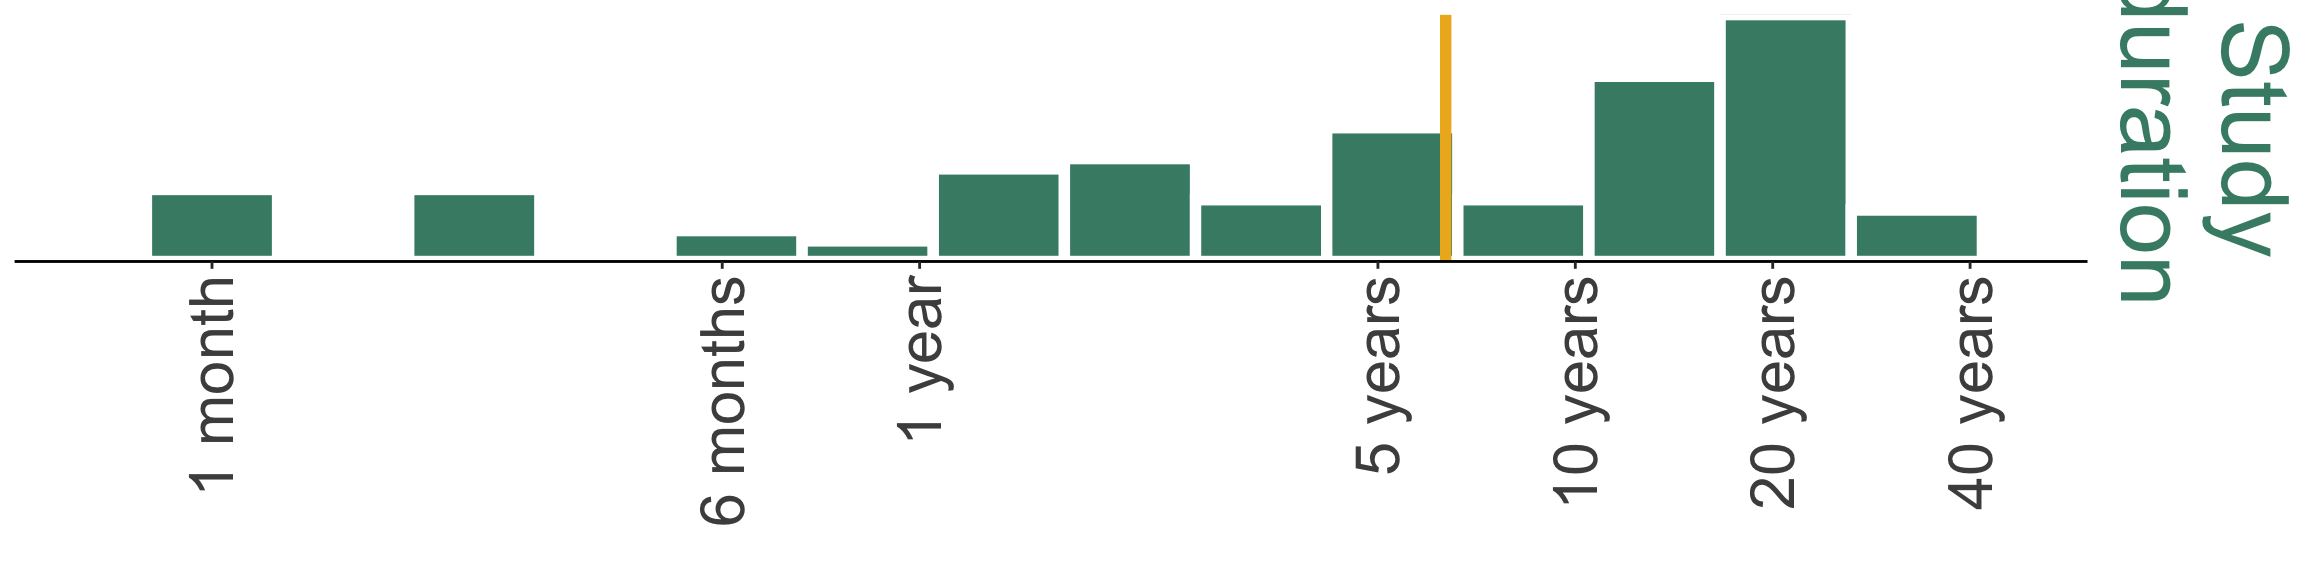

Removed 2 rows containing missing values or values outside the scale range
(`geom_bar()`).

In [ ]:

studyDurationPlot <-
  sheet_DataCollection |>
    mutate(`Start month` = case_when(str_detect(`Start month`, "[:digit:]{5}") ~ `Start month`,
                                     .default = NA),
           `End month` = case_when(str_detect(`End month`, "[:digit:]{5}") ~ `End month`,
                                     .default = NA)) |>
  mutate(StartDay = as.numeric(as.Date(as.numeric(`Start month`))),
         EndDay = as.numeric(as.Date(as.numeric(`End month`)))) |>
  mutate(StudyDuration = EndDay - StartDay) |>
  mutate(StudyMonths = (StudyDuration/30)) |>
  mutate(StudyMonths = case_when(StudyMonths == 0 ~ 1,
                                 .default = StudyMonths)) |>
  
  ggplot() +
  geom_histogram(aes(x = StudyMonths), 
                 binwidth = 0.2, fill = "aquamarine4", colour = "white",
                 linewidth = 2) +
  geom_vline(aes(xintercept = median(StudyMonths, na.rm = TRUE)), 
             colour = "goldenrod2", linetype = 1, linewidth = 2) +
  labs(x = "", y = "Study\nduration") +
  scale_x_continuous(transform = "log10",
                     limits = c(0.5,725),
                     breaks = c(1, 6, 12, 60, 
                                120, 240, 480), 
                     labels = c("1 month", "6 months", "1 year", "5 years", 
                                "10 years", "20 years", "40 years"),
                     expand = c(0,0)) +
  scale_y_continuous(expand = c(0,0), position = "right") +
  theme(panel.grid = element_blank(),
        panel.background = element_rect(fill='transparent', color=NA),
        plot.background = element_rect(fill='transparent', color=NA),
        axis.text.x = element_text(size = 23, angle = 90,
                                   vjust = 0.5, hjust = 1),
        axis.text.y = element_blank(), axis.ticks.y = element_blank(),
        axis.line.x = element_line(), 
        axis.title.y = element_text(size = 35, colour = "aquamarine4"))
studyDurationPlot


In [ ]:

combinedStudyScale <- siteQuantityPlot / studyDurationPlot
combinedStudyScale <- combinedStudyScale +
  theme(panel.background = element_rect(fill='transparent', color=NA),
        plot.background = element_rect(fill='transparent', color=NA))
ggsave(plot = combinedStudyScale, filename = "Figures/StudyScale.png",
       height = 6, width = 12)


(`stat_bin()`).

(`geom_bar()`).

(`stat_bin()`).

(`geom_bar()`).